<a href="https://colab.research.google.com/github/davepriyan/test_rep/blob/master/DSIProj_DGunaratnam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Discovering Recurring Patterns

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import *
import time
import seaborn as sns
import dtw
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import matplotlib.patches as mpatches

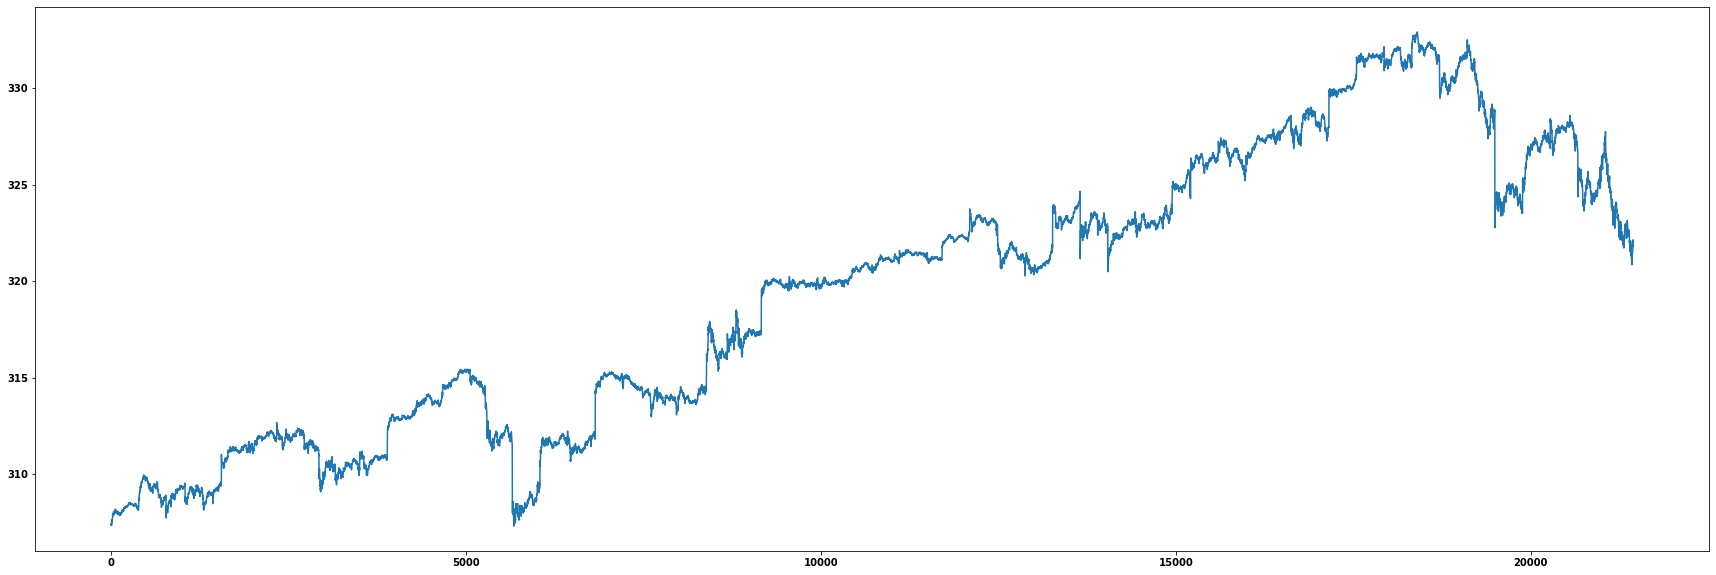

In [0]:
mydata = pd.read_table("timeseries.data", header = None)
fig= plt.figure(figsize=(30,10))
plt.plot(mydata)

### Sudden Drop

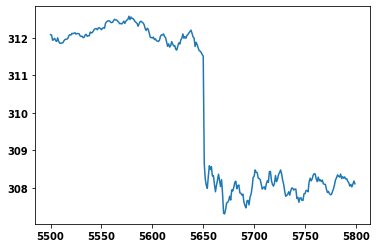

In [0]:
plt.plot(mydata[5500:5800])
a = np.array(mydata[5500:5800])

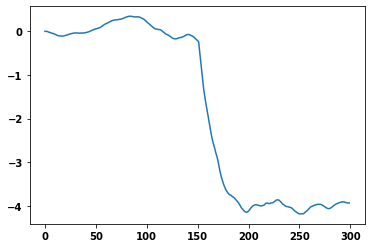

In [0]:
#use exponential smoothing to smooth out the curve. Use this as a base case for a sudden drop scenario 
fit1 = SimpleExpSmoothing(a).fit(smoothing_level=0.07,optimized=False)
drop = fit1.fittedvalues - fit1.fittedvalues[0]
plt.plot(drop)

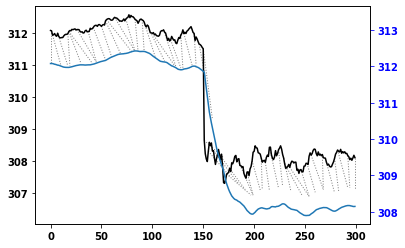

52.54536044621375


In [0]:
from dtw import *
alignment = dtw(a, fit1.fittedvalues, keep_internals=True)
alignment.plot(type="twoway", offset=-1)
print(alignment.distance)
#print(fit1.fittedvalues)

### Sudden Jump

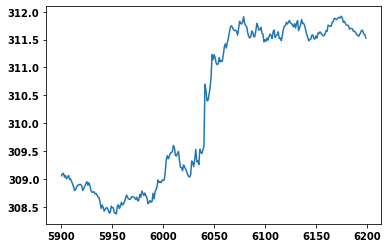

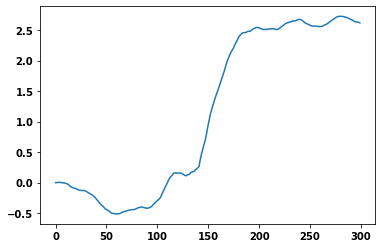

In [0]:
plt.plot(mydata[5900:6200])
plt.show()
a = np.array(mydata[5900:6200])
fit2 = SimpleExpSmoothing(a).fit(smoothing_level=0.07,optimized=False)
jump = fit2.fittedvalues - fit2.fittedvalues[0]
plt.plot(jump)

### Local Maximum

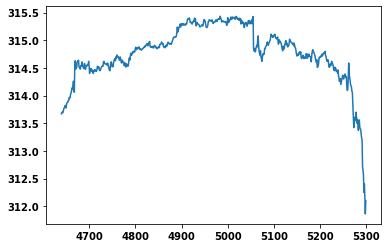

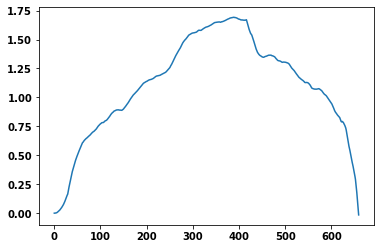

In [0]:
plt.plot(mydata[4640:5300])
plt.show()
a = np.array(mydata[4640:5300])
fit3 = SimpleExpSmoothing(a).fit(smoothing_level=0.03,optimized=False)
local_max = fit3.fittedvalues - fit3.fittedvalues[0]
plt.plot(local_max)

### Relatively Flat

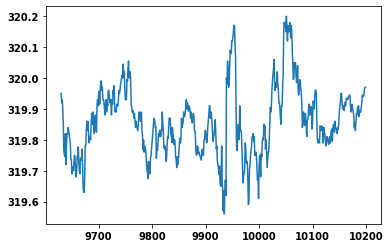

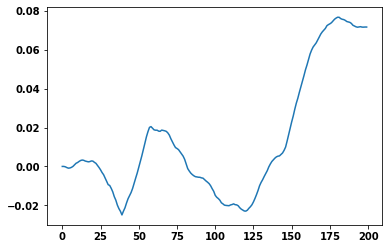

In [0]:
plt.plot(mydata[9630:10200])
plt.show()
a = np.array(mydata[9900:10100])
fit4 = SimpleExpSmoothing(a).fit(smoothing_level=0.01,optimized=False)
rel_flat = fit4.fittedvalues - fit4.fittedvalues[0]
plt.plot(rel_flat)

In [0]:
X = np.array([[0,0]])
Y = np.array([0])
#plt.plot(drop)


def DTWMetric(x):
    A = np.empty(4)
    a = np.array(mydata[x[0]:x[1]])
    a = a - a[0]
    
    A[0] = dtw(a, drop, keep_internals=True).distance
    A[1] = dtw(a, jump, keep_internals=True).distance
    A[2] = dtw(a, local_max, keep_internals=True).distance
    A[3] = dtw(a, rel_flat, keep_internals=True).distance
    #print(A[0], A[1])
    
    sort = np.argsort(A)
    dis = np.sort(A)
    if(dis[0] >= 150):
        return -1
    elif(sort[0] == 3 and dis[0] >= 70):
        return -1
    else:
        return sort[0]

In [0]:
size = 300
i = 0
while i < mydata.shape[0]:
    temp = np.array(mydata[i:i+size])
    begin = i
    end = i+size
    if(np.max(temp)-np.min(temp) >= 0):
        label = DTWMetric([i,i+size])
        X = np.append(X, [[i,i+size]], axis = 0)
        Y = np.append(Y, label)
    i = i + size

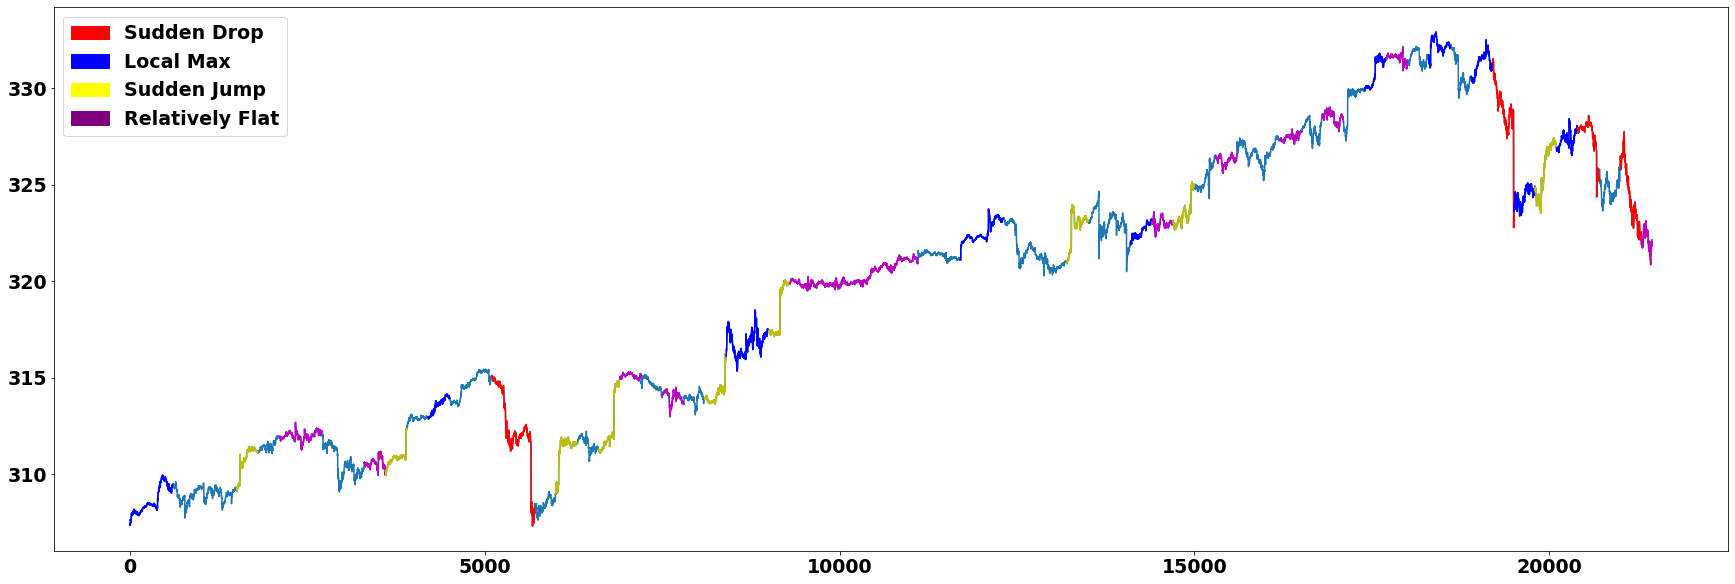

In [0]:
fig= plt.figure(figsize=(30,10))
plt.plot(mydata)
i=0
while i < X.shape[0]:
    sub = mydata.iloc[X[i][0]:X[i][1]]
    if(Y[i] == 0):
        plt.plot(sub, 'r-')
    elif(Y[i] == 1):
        plt.plot(sub, 'y-')
    elif(Y[i] == 2):
        plt.plot(sub, 'b-')
    elif(Y[i] == 3):
        plt.plot(sub, 'm-')
    i = i+1
    
red = mpatches.Patch(color='red', label='Sudden Drop')
blue = mpatches.Patch(color='blue', label='Local Max')
yellow = mpatches.Patch(color='yellow', label='Sudden Jump')
magenta = mpatches.Patch(color='purple', label='Relatively Flat')
plt.legend(handles=[red, blue, yellow, magenta])
font = {'family' : 'normal',
        'size'   : 19}
plt.rc('font', **font)
#plt.legend(loc="upper left")
plt.show()

# Synthetic Data Generation

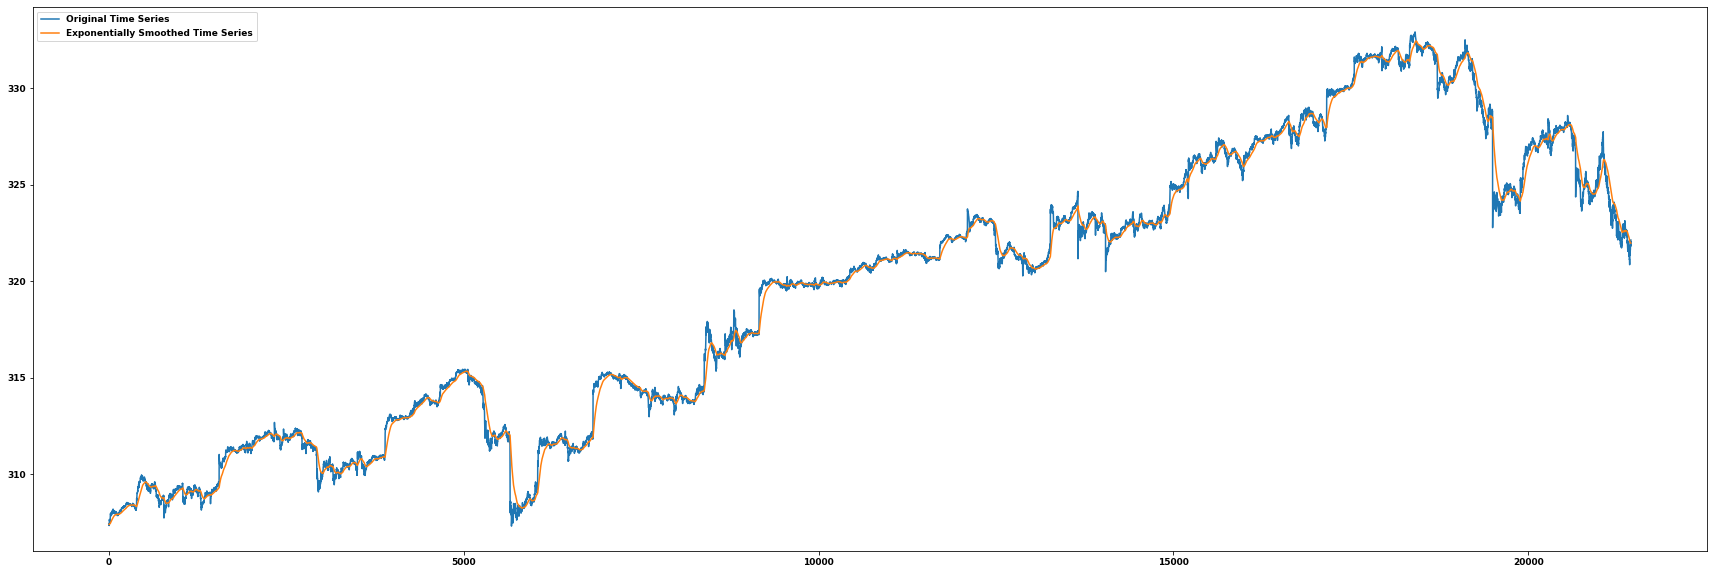

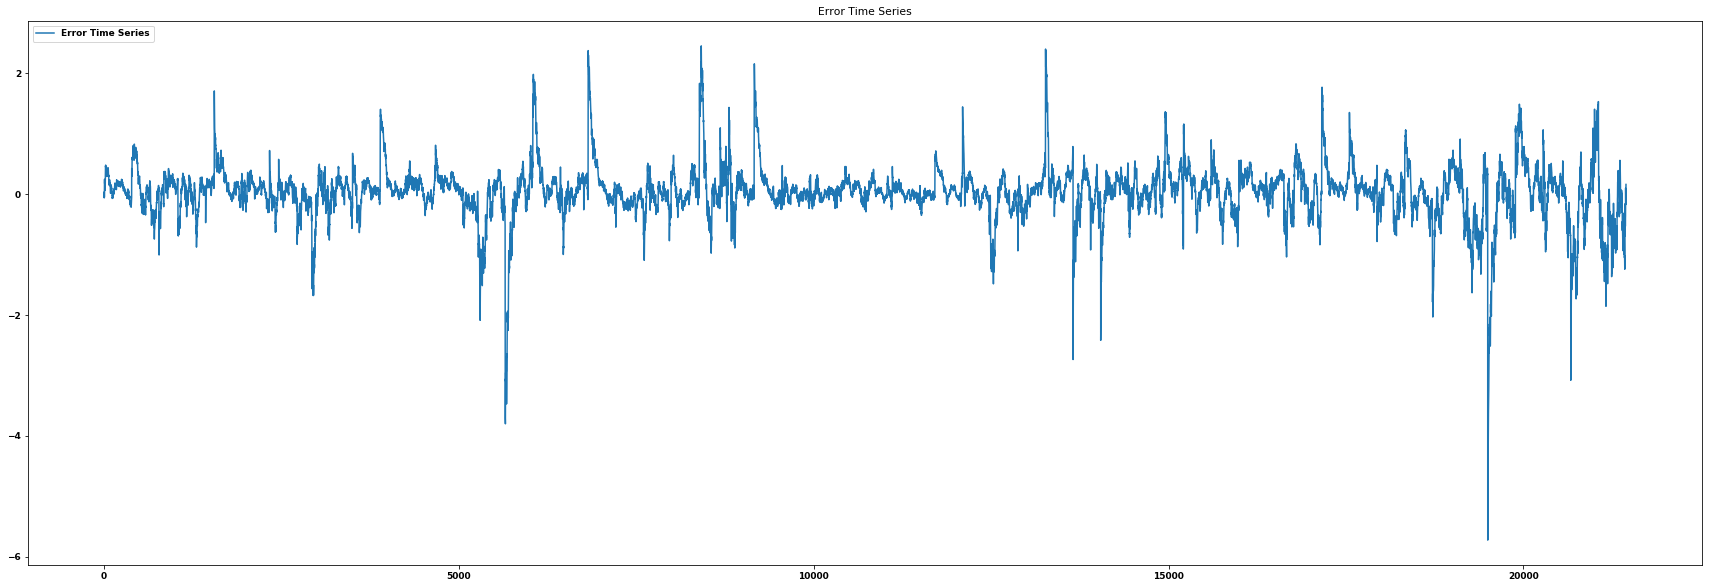

In [0]:
fig= plt.figure(figsize=(30,10))
plt.plot(mydata, label = "Original Time Series")

#constructing an exponentially smoothed version of the time series and creating the error array that measures
#the distance between the actual level of the time series and the corresponding exponentially smoothed level
arr = np.array(mydata)
arr = arr.reshape(len(arr),)
fit1 = SimpleExpSmoothing(arr).fit(smoothing_level=0.02,optimized=False)
plt.plot(fit1.fittedvalues, label = "Exponentially Smoothed Time Series")
plt.legend(loc="upper left")
plt.show()
error = arr - fit1.fittedvalues
fig= plt.figure(figsize=(30,10))
plt.title("Error Time Series")
plt.plot(error, label = "Error Time Series")
plt.legend(loc="upper left")
plt.show()


#### Performing Augmented Dickey Fuller test on error time series to test for stationarity of the time series. 

In [0]:
#Performing Augmented Dickey Fuller test on error time series to test for stationarity of the time series. 

from statsmodels.tsa.stattools import adfuller
result = adfuller(error)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
print("From the ADF test statistic and P value we can conclude that the time series is stationary")

ADF Statistic: -14.649949
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
From the ADF test statistic and P value we can conclude that the time series is stationary


In [0]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess

#### Finding estimates for p & q in the ARMA model

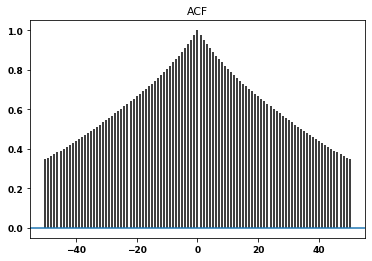

In [0]:
#finding estimates for p & q in the ARMA model.

#autocorrelation_plot(error, maxlags = 20)
#print(first_difference, flush = True)
plt.acorr(error, maxlags = 50)
font = {'family' : 'normal',
        'size'   : 9}
plt.rc('font', **font)
plt.title("ACF")
plt.show()

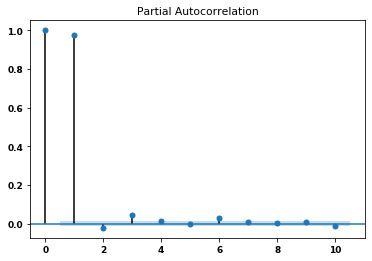

In [0]:
plot_pacf(error, lags = 10)
plt.show()

<font color = 'Blue'>
 This ACF and PCF graph suggest two things. Since the ACF graph is decaying exponentially and PCF graph spikes at t=1 and then falls to zero, by the methodology suggested by Hyndman, we estimate that this process is purely autoregressive with p = 1 and q = 0. Since we showed that the error process is stationary we can set d = 0.    
    
</font>

#### Fitting the ARMA model

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                21446
Model:                     ARMA(1, 0)   Log Likelihood               19331.990
Method:                       css-mle   S.D. of innovations              0.098
Date:                Mon, 24 Feb 2020   AIC                         -38657.979
Time:                        21:57:40   BIC                         -38634.059
Sample:                             0   HQIC                        -38650.180
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0341      0.028      1.219      0.223      -0.021       0.089
ar.L1.y        0.9761      0.001    659.120      0.000       0.973       0.979
                                    Roots           

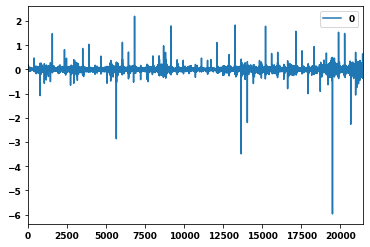

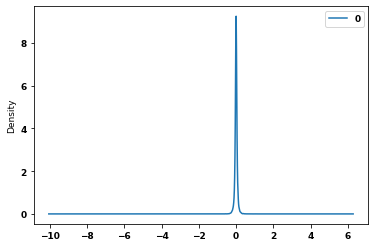

                  0
count  21446.000000
mean       0.000002
std        0.098233
min       -5.969847
25%       -0.029549
50%       -0.000284
75%        0.029418
max        2.199358


In [0]:
p = 1
d = 0 
q = 0
model = ARIMA(error, order=(p,d,q))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

#### Creating an ARMA process and Simulating a Time series

In [0]:
arParam = model_fit.params[1:p+1]
maParam = model_fit.params[p+1:q+p+1]
arParam = np.r_[1, -arParam] # add zero-lag and negate
maParam = np.r_[1, maParam] # add zero-lag
print(maParam)
print(arParam)

[1.]
[ 1.         -0.97610986]


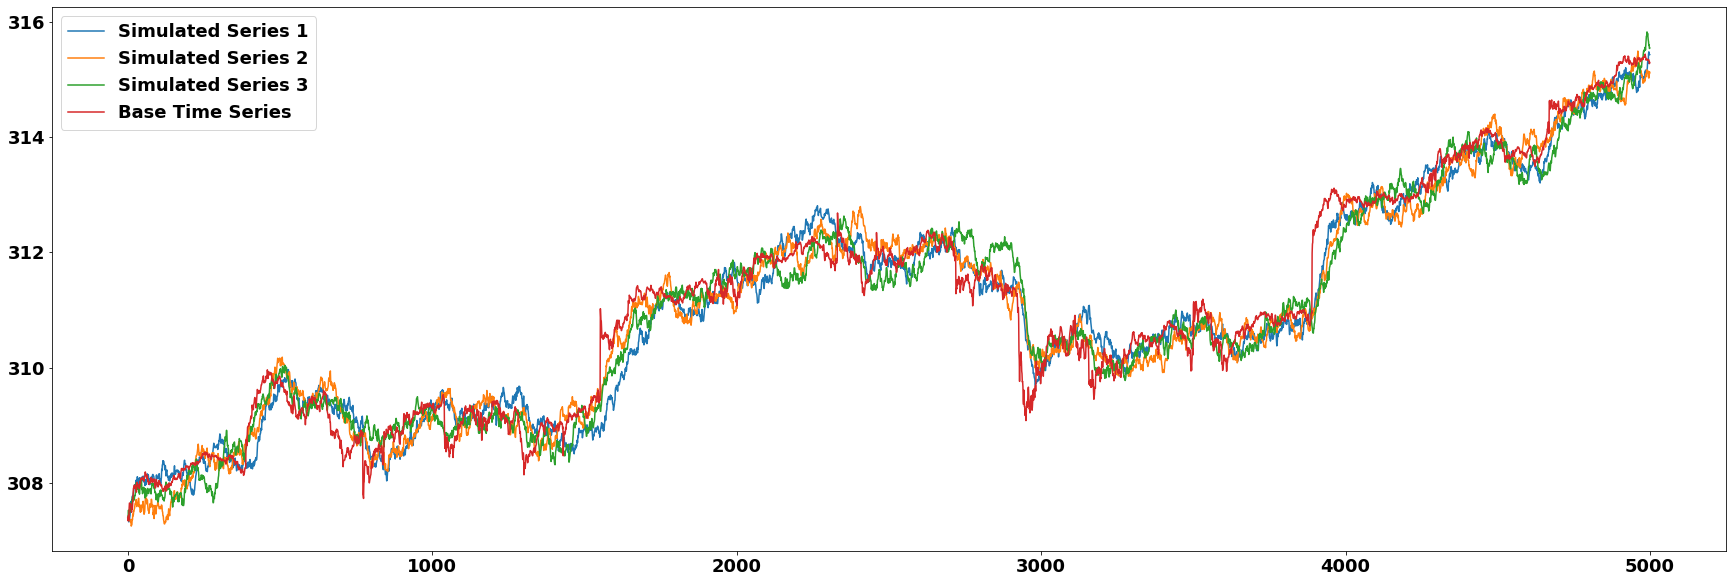

In [0]:
N = mydata.shape[0]
start = 0
end = 5000

def create_simulated_series():
    arma_process = ArmaProcess(arParam, maParam)
    y = arma_process.generate_sample(N, scale = 0.05)
    simulated_time_series = np.array([arr[0]])
    for i in range(N-1):
        simulated_time_series = np.append(simulated_time_series, fit1.fittedvalues[i] + y[i])
    #simulated_time_series = np.append(simulated_time_series, fit1.fittedvalues[i] + np.random.normal(0,.05))
    return simulated_time_series[start:end]


font = {'family' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
fig= plt.figure(figsize=(30,10))
plt.plot(create_simulated_series(), label = "Simulated Series 1")
plt.plot(create_simulated_series(), label = "Simulated Series 2")
plt.plot(create_simulated_series(), label = "Simulated Series 3")
plt.plot(mydata[start:end], label = "Base Time Series")
plt.legend(loc="upper left")
plt.show()
font = {'family' : 'normal',
        'size'   : 9}
plt.rc('font', **font)

Orange Distribution is the Synthetic Error Distribution
Blue Distribution is the True Error Distribution


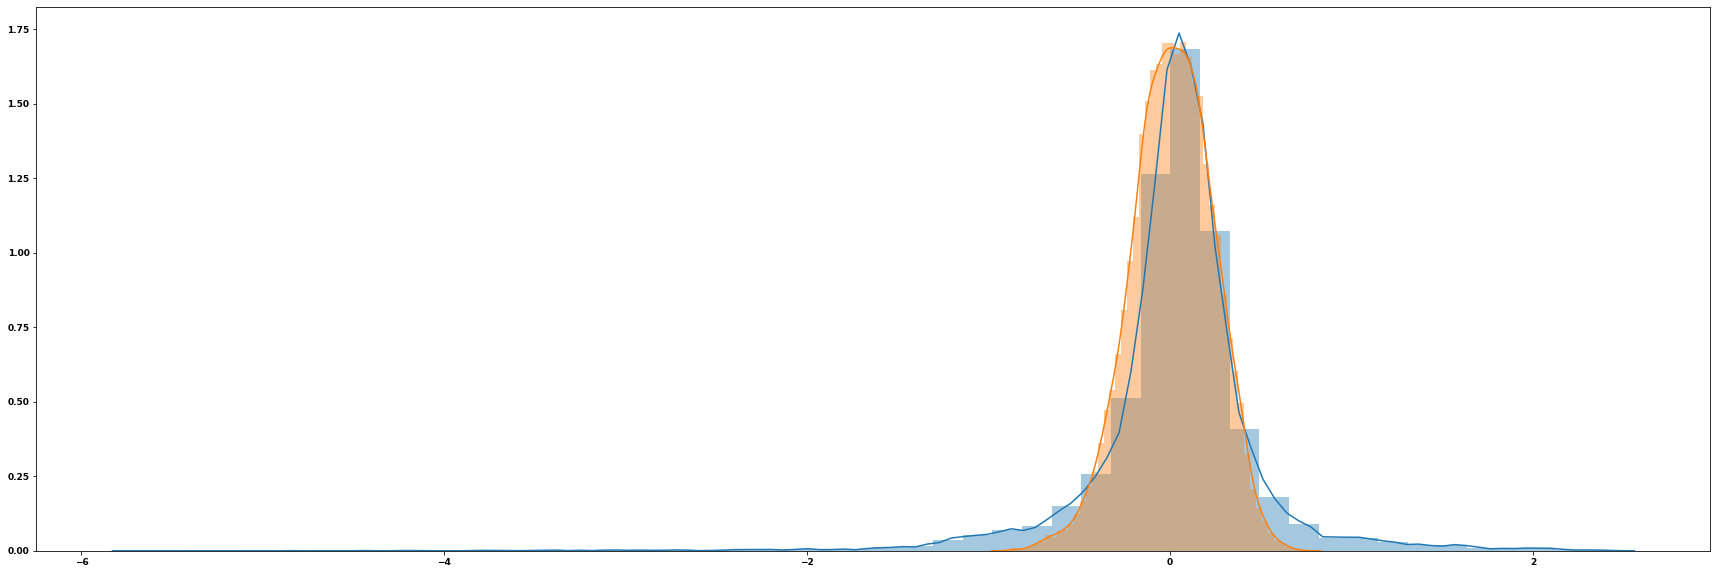

In [0]:
from scipy.stats import ks_2samp
fig= plt.figure(figsize=(30,10))

sns.distplot(error, label= "True Error Distribution")
sns.distplot(y,label = "Synthetic Error Distribution")
print("Orange Distribution is the Synthetic Error Distribution")
print("Blue Distribution is the True Error Distribution")

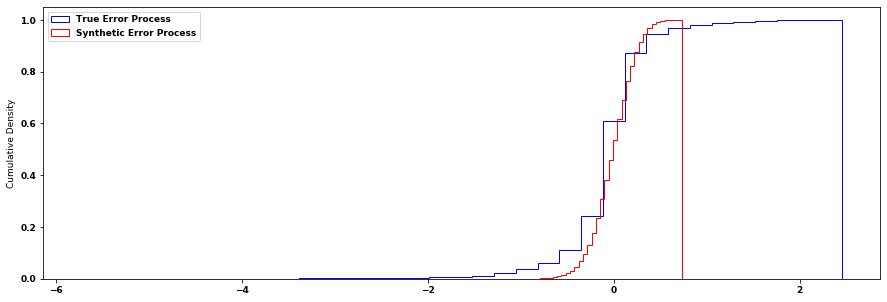

In [0]:
#here are the CDFs of the two distributions
fig, axs = plt.subplots(1, 1,figsize=(15,5))
axs.hist(error, 35,color = 'blue',density=True, histtype='step',cumulative=True, label='True Error Process')
axs.hist(y, 35,color = 'red',density=True, histtype='step',cumulative=True, label='Synthetic Error Process')
axs.set_title('')
axs.set_xlabel('')
axs.set_ylabel('Cumulative Density')
axs.legend(prop={'size': 10})
axs.legend(loc='upper left')

# Forecasting

In [0]:
labels = np.empty(0)
i = 0
while i+60 <= (len(arr)):
    max_value = np.max(arr[i:i+60])
    labels = np.append(labels, max_value)
    i = i+60
print(labels.shape)
#print(labels)
#print(np.max(arr[180:240]))

(357,)


#### Exponentially Weighted Moving Averages

In [0]:
EWMA20 =mydata.ewm(span=20).mean()
EWMA5 =mydata.ewm(span=5).mean()

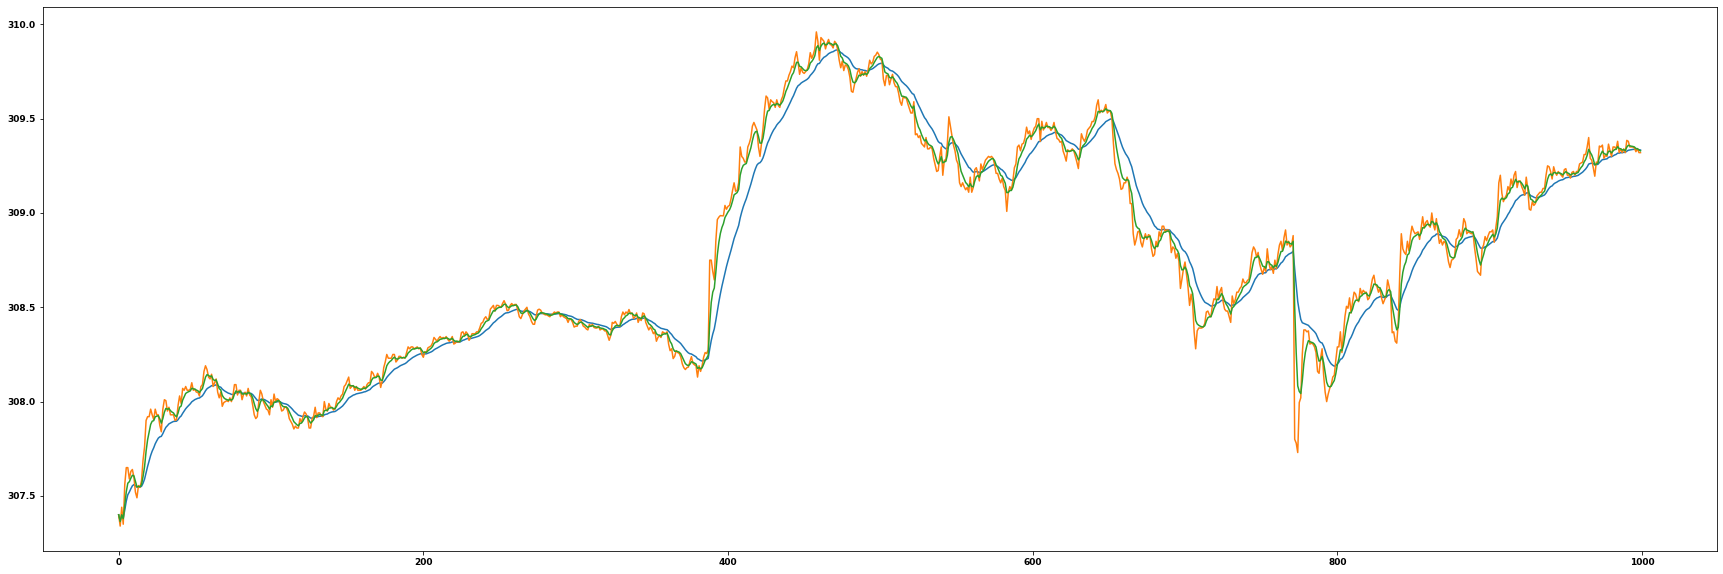

In [0]:
fig= plt.figure(figsize=(30,10))
plt.plot(EWMA20[0:1000])
plt.plot(mydata[0:1000])
plt.plot(EWMA5[0:1000])
#print(EWMA5[120:180])

#### Relative Strength Index

In [0]:
diff = np.diff(arr)
dUp, dDown = diff.copy(), diff.copy()
dUp[dUp < 0] = 0

dDown[dDown > 0] = 0
dDown = dDown * -1

fit = SimpleExpSmoothing(dUp).fit(smoothing_level=0.07,optimized=False)
fit2 = SimpleExpSmoothing(dDown).fit(smoothing_level=0.07,optimized=False)
RSI = 100 - (100/(1+ (fit.fittedvalues/fit2.fittedvalues)))

RSI = np.insert(RSI, 0, 0)
print(RSI.shape)


(21446,)


#### Close relative to 5 step range

In [0]:
#Close relative to 5T Range
print(arr[0:4])
CRTR = np.empty(0)
i = 0
while i+5 <= (len(arr)):
    maxL = np.max(arr[i:i+5])
    minL = np.min(arr[i:i+5])
    val = (arr[i+4] - minL)/(maxL - minL)
    CRTR = np.append(CRTR, val)
    i = i + 1

for i in range(4):
    CRTR = np.insert(CRTR,0,0.5)

[307.4  307.34 307.44 307.35]


C:\Users\Dave\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


#### Realized Volatility - 50 periods

In [0]:
#Realized Volatility
returns = (np.diff(np.log(arr)) * 100) ** 2
returns = np.insert(returns, 0,0)
rel_vol = pd.Series(returns)
MA_vol = rel_vol.rolling(50).mean() *1000
#MA_vol = MA_vol * 1000

Now you have your 3 technical indicators and your labels. What you need to do is no aggregate each 60 points into one line vector. You'll have (60 * 4). So your vector will be 240 dimensional. 

#### Constructing feature vectors

In [0]:
X_matrix = np.empty((0,300))
i = 0
while i+60 < len(arr):
    x = np.empty(0)
    x = np.append(x, EWMA5[i:i+60])
    x = np.append(x, EWMA20[i:i+60])
    x = np.append(x, RSI[i:i+60])
    x = np.append(x, CRTR[i:i+60])
    x = np.append(x, MA_vol[i:i+60])
    x = x.reshape(1,300)
    X_matrix = np.append(X_matrix, x, axis = 0)
    i = i+60
print(X_matrix.shape)
print(labels.shape)
X_matrix = np.nan_to_num(X_matrix)
print(numpy.isnan(X_matrix).any())
A = X_matrix[0]
B = labels[1]

(357, 300)
(357,)
False


In [0]:
X_matrix = np.delete(X_matrix, 0, axis = 0)
labels = np.delete(labels, 0)
labels = np.delete(labels, 0)
X_matrix = np.delete(X_matrix, -1, axis = 0)

### Training Random Forest Regressor

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

#### Testing with last 15% of time points

False
Model R^2:  0.9219537079603437


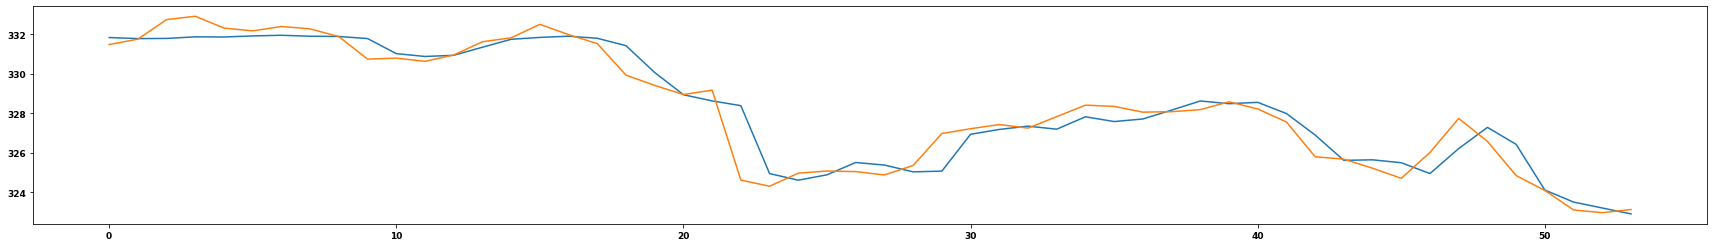

MSE: 0.6896387562661184
MAD: 0.5574405273992953
MAPE: 0.17013459888592447 %


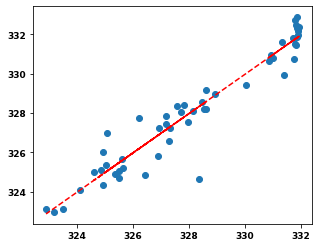

In [0]:
clf = RandomForestRegressor(n_estimators = 200, min_samples_leaf = 2)
X_train, X_test, y_train, y_test = train_test_split(X_matrix, labels, test_size=0.15, shuffle = False)
RF_model = clf.fit(X_train, y_train)
print(numpy.isnan(X_train).any())
print ("Model R^2: ", RF_model.score(X_test, y_test))

K = RF_model.predict(X_test)
fig= plt.figure(figsize=(30,4))
plt.plot(K)
plt.plot(y_test)
plt.show()

MSE = np.sum(np.square(np.abs(K-y_test)))/np.size(K)
print("MSE:", MSE)
MAD = np.sum(np.abs(K-y_test))/np.size(K)
print("MAD:", MAD)
MAPE = np.sum(np.abs(((K-y_test)/y_test)))/np.size(K) * 100
print("MAPE:", MAPE, "%")

fig= plt.figure(figsize=(5,4))
plt.scatter(K,y_test)
z = numpy.polyfit(K,y_test, 1)
p = numpy.poly1d(z)
plt.plot(K,p(K),"r--")
plt.show()

#### Testing with last 20% of time points

False
Model R^2:  0.4709527227844942


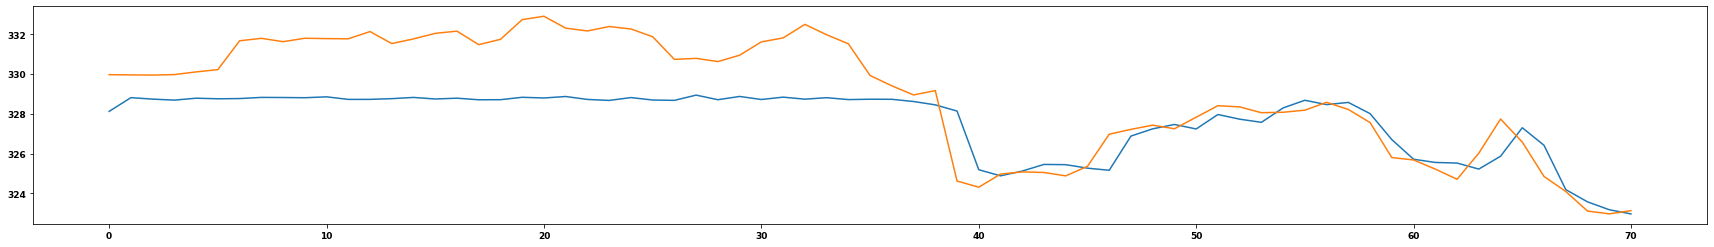

MSE: 4.48029736780848
MAD: 1.6778802869299865
MAPE: 0.5073348245439081 %


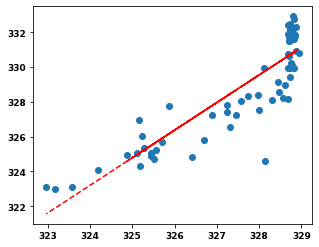

Feature Importance: [8.81631938e-04 1.30137355e-02 7.69170029e-04 8.85562000e-03
 1.67047993e-02 4.14819867e-03 4.06518461e-03 3.52813715e-05
 2.41210123e-05 9.05409996e-04 4.62830042e-03 9.05963635e-05
 5.50502775e-05 3.63890384e-04 1.21560952e-03 3.64838960e-05
 3.98330020e-05 2.66870546e-05 7.97954097e-05 4.39820938e-03
 4.23528095e-03 8.93970261e-04 1.05943780e-04 4.52177210e-03
 1.45694464e-03 4.60622165e-04 2.59713083e-03 4.87856110e-03
 2.88840100e-04 1.71745335e-04 9.81787254e-04 4.18000047e-03
 2.21692352e-04 8.85530244e-03 2.06614456e-02 1.71360964e-02
 4.44027778e-03 1.12229697e-02 1.39763156e-02 2.44865660e-02
 9.90962997e-04 9.93631410e-03 1.87524862e-03 1.05340957e-02
 5.71379845e-03 9.94172023e-03 6.01918036e-03 6.74962053e-03
 3.25001967e-03 8.86134034e-03 4.36827166e-03 1.46016293e-02
 6.91513911e-03 1.33320000e-02 2.63673904e-02 7.41671369e-02
 6.30175794e-02 7.71694699e-02 7.46181443e-02 8.64760944e-02
 1.35651566e-02 1.64626127e-03 5.10283874e-03 1.62361063e-03
 4.1

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_matrix, labels, test_size=0.20, shuffle = False)
RF_model = clf.fit(X_train, y_train)
print(numpy.isnan(X_train).any())
print ("Model R^2: ", RF_model.score(X_test, y_test))
K = RF_model.predict(X_test)
fig= plt.figure(figsize=(30,4))
plt.plot(K)
plt.plot(y_test)
plt.show()

MSE = np.sum(np.square(np.abs(K-y_test)))/np.size(K)
print("MSE:", MSE)
MAD = np.sum(np.abs(K-y_test))/np.size(K)
print("MAD:", MAD)
MAPE = np.sum(np.abs(((K-y_test)/y_test)))/np.size(K) * 100
print("MAPE:", MAPE, "%")

fig= plt.figure(figsize=(5,4))
plt.scatter(K,y_test)
z = numpy.polyfit(K,y_test, 1)
p = numpy.poly1d(z)
plt.plot(K,p(K),"r--")
plt.show()
print("Feature Importance:", RF_model.feature_importances_)